# D.1. Risk and Return

## Module: Risk

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

# Import Packages, Settings

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import seaborn as sns
#import statsmodels.api as sm

In [3]:
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

***

# Asset Class ETFs

In [4]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

display(info)
display(retsx)

,ETF Description
Symbol,
SPY,Domestic Equity SPDR S&P500
EFA,Foreign Equity iShares EAFE
EEM,iShares Emerging Markets
PSP,Private Equity Invesco Global Private Equity
QAI,Absolute Return IQ Multi-Strat
HYG,High Yield iShares High Yield Corporate Bond
DBC,Invesco DB Commodity Index Tracking Fund
IYR,Real Estate iShares US Real Estate
IEF,Domestic Bonds iShares 7-10 Year Treasury


,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
Date,,,,,,,,,,,
2009-04-30,0.0988,0.1146,0.1550,0.2296,0.0223,0.1379,-0.0016,0.2956,-0.0280,0.0084,-0.0185
2009-05-31,0.0589,0.1324,0.1599,0.0544,0.0283,0.0290,0.1631,0.0232,-0.0203,0.0541,0.0204
2009-06-30,-0.0013,-0.0146,-0.0231,0.0448,-0.0040,0.0329,-0.0269,-0.0255,-0.0062,0.0045,0.0014
2009-07-31,0.0746,0.1004,0.1102,0.1433,0.0154,0.0692,0.0186,0.1058,0.0083,0.0313,0.0009
2009-08-31,0.0365,0.0446,-0.0136,0.0330,-0.0046,-0.0174,-0.0408,0.1315,0.0072,0.0072,0.0080
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,0.0529,0.0295,0.0120,0.0765,0.0060,0.0064,0.0783,0.0789,0.0100,0.0172,0.0143
2021-05-31,0.0066,0.0348,0.0165,0.0186,0.0059,0.0004,0.0385,0.0101,0.0042,0.0098,0.0102
2021-06-30,0.0226,-0.0106,0.0097,-0.0029,0.0027,0.0134,0.0351,0.0228,0.0104,-0.0171,0.0074


In [5]:
mets = performanceMetrics(retsx,annualization=12)

mets.sort_values('Sharpe',ascending=False)

,Mean,Vol,Sharpe,Min,Max
SPY,0.1649,0.1392,1.1850,-0.1290,0.1268
HYG,0.0812,0.0860,0.9442,-0.1044,0.1379
IYR,0.1643,0.1801,0.9124,-0.2005,0.2956
TIP,0.0372,0.0452,0.8248,-0.0418,0.0396
PSP,0.1702,0.2134,0.7977,-0.2789,0.2296
EFA,0.0992,0.1613,0.6152,-0.1452,0.1429
IEF,0.0334,0.0569,0.5875,-0.0440,0.0461
QAI,0.0278,0.0478,0.5815,-0.0605,0.0340
EEM,0.0931,0.1962,0.4746,-0.1791,0.1628
BWX,0.0208,0.0743,0.2802,-0.0684,0.0612


MIN Correlation pair is ('SPY', 'IEF')
MAX Correlation pair is ('PSP', 'EFA')


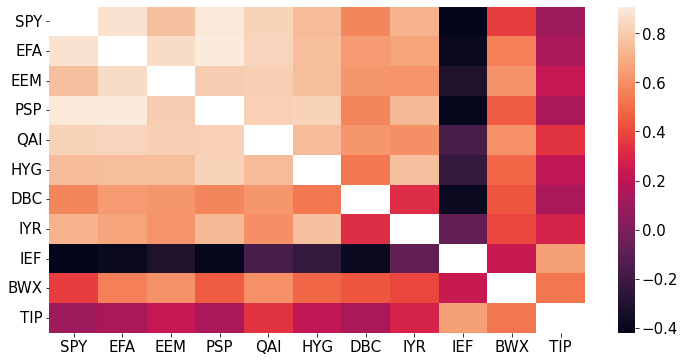

In [6]:
corrmat = retsx.corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)

corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

### TIPS

TIPS have one of the highest Sharpe ratios--they have a low mean, but a very low volatility. Furthermore, they have outperformed Domestic bonds in terms of mean and in terms of volatility.

Notably, TIPS have very low correlation to the other assets--including relatively low coorrelation to IEF (Domestic Bonds). In the correlation heat map above, we see that TIPS provide a great deal of diversification to all assets except IEF, to which they still provide some diversification.

***

# Commodities Data

### Source: Nasdaq Data (formerly quandl)

In [7]:
info = pd.read_excel('../data/commodities_return_data.xlsx',sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel('../data/commodities_return_data.xlsx',sheet_name='total returns')
rets.set_index('Date',inplace=True)

retsx = rets.subtract(0,axis=0)

In [8]:
retsx

,CL1,NG1,KC1,CC1,LB1,CT1,SB1,LC1,W1,S1,C1,GC1,SI1,HG1,PA1
Date,,,,,,,,,,,,,,,
2000-01-31,0.0797,0.1430,-0.1176,-0.0502,-0.0069,0.1403,-0.1144,0.0245,0.0312,0.1002,0.0758,-0.0221,-0.0233,-0.0100,0.0790
2000-02-29,0.1009,0.0372,-0.1008,-0.0528,-0.0473,-0.0218,-0.1421,-0.0057,-0.0361,-0.0133,-0.0227,0.0388,-0.0452,-0.0675,0.4689
2000-03-31,-0.1160,0.0666,0.0380,0.0624,-0.0167,0.0272,0.2688,0.0347,0.0617,0.0883,0.0977,-0.0537,-0.0055,0.0165,-0.1636
2000-04-30,-0.0431,0.0666,-0.0810,-0.0663,-0.0776,-0.0418,-0.1254,0.0288,-0.0763,-0.0348,-0.0519,-0.0133,-0.0120,-0.0125,0.0421
2000-05-31,0.1270,0.3868,-0.0241,0.1272,-0.0083,0.1244,0.4632,-0.0873,0.1342,-0.0171,0.0056,-0.0109,-0.0038,0.0266,-0.0624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28,0.1782,0.0807,0.1131,0.0672,0.1224,0.0890,0.0392,-0.0169,-0.0121,0.0257,0.0155,-0.0654,-0.0190,0.1458,0.0424
2021-03-31,-0.0380,-0.0588,-0.0976,-0.1307,0.0136,-0.0790,-0.1021,0.0696,-0.0565,0.0224,0.0158,-0.0092,-0.0722,-0.0223,0.1324
2021-04-30,0.0747,0.1238,0.1332,-0.0026,0.4870,0.0810,0.1496,-0.0411,0.2015,0.0934,0.3115,0.0304,0.0538,0.1189,0.1274


In [9]:
performanceMetrics(retsx,annualization=12, quantile=.01)

,Mean,Vol,Sharpe,Min,Max
CL1,0.1239,0.3915,0.3165,-0.5424,0.8838
NG1,0.1592,0.5383,0.2958,-0.4162,0.6261
KC1,0.0602,0.3203,0.1879,-0.2260,0.4361
CC1,0.1000,0.3248,0.3079,-0.2808,0.3456
LB1,0.1462,0.4000,0.3654,-0.3403,0.5842
CT1,0.0725,0.3069,0.2362,-0.3612,0.2475
SB1,0.1066,0.3468,0.3074,-0.3125,0.4632
LC1,0.0448,0.1875,0.2390,-0.2160,0.1615
W1,0.0913,0.3120,0.2926,-0.2525,0.4233
S1,0.0865,0.2651,0.3263,-0.3287,0.1957


In [10]:
tailMetrics(rets,mdd=False)

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
CL1,1.2276,15.0760,-0.1556,-0.2245
NG1,0.7092,1.8678,-0.1981,-0.2954
KC1,0.8061,1.7140,-0.1186,-0.1563
CC1,0.3591,0.9553,-0.1300,-0.1698
LB1,0.8619,3.4599,-0.1374,-0.2187
CT1,-0.1298,0.8956,-0.1309,-0.1878
SB1,0.5488,1.8302,-0.1379,-0.1819
LC1,-0.2740,1.0506,-0.0909,-0.1211
W1,0.5511,1.6098,-0.1251,-0.1651
S1,-0.5408,1.4258,-0.1223,-0.1783


In [11]:
maximumDrawdown(retsx)

,Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
CL1,-0.8654,2008-06-30,2020-04-30,NaN,None
NG1,-0.8822,2005-09-30,2020-03-31,NaN,None
KC1,-0.6932,2011-04-30,2019-04-30,NaN,None
CC1,-0.5092,2011-02-28,2017-04-30,NaN,None
LB1,-0.6663,2004-08-31,2009-02-28,2017-10-31 00:00:00,None
CT1,-0.7508,2011-02-28,2020-03-31,None,None
SB1,-0.6947,2011-01-31,2020-04-30,None,None
LC1,-0.4671,2014-11-30,2020-04-30,None,None
W1,-0.6636,2008-02-29,2016-08-31,None,None
S1,-0.5279,2012-08-31,2018-08-31,None,None


# Correlation Statistics

MIN Correlation pair is ('GC1', 'LC1'):
Gold, COMEX Gold Futures with Cattle, CME Live Cattle Futures.

MAX Correlation pair is ('GC1', 'SI1'):
Gold, COMEX Gold Futures with Silver, COMEX Silver Futures.


,CL1,NG1,KC1,CC1,LB1,CT1,SB1,LC1,W1,S1,C1,GC1,SI1,HG1,PA1
CL1,NaN,0.1786,0.0894,0.1698,0.2895,0.1749,0.1929,0.1412,0.0493,0.1308,0.1330,0.1534,0.3162,0.3740,0.2203
NG1,0.1786,NaN,0.0348,-0.0221,-0.0384,0.0083,0.1126,-0.0244,0.1247,0.0870,0.1382,0.0898,0.0786,0.0935,0.0557
KC1,0.0894,0.0348,NaN,0.2636,0.1662,0.2564,0.2345,0.0413,0.2974,0.2575,0.2743,0.2540,0.3138,0.2565,0.2088
CC1,0.1698,-0.0221,0.2636,NaN,0.1573,0.2155,0.1670,-0.0125,0.0959,0.1319,0.1735,0.1473,0.2208,0.1759,0.1681
LB1,0.2895,-0.0384,0.1662,0.1573,NaN,0.1501,0.0908,0.1135,0.1646,0.1798,0.1524,0.1137,0.2534,0.2485,0.2175
CT1,0.1749,0.0083,0.2564,0.2155,0.1501,NaN,0.1909,0.0509,0.1918,0.3604,0.3482,0.0881,0.1668,0.2933,0.2119
SB1,0.1929,0.1126,0.2345,0.1670,0.0908,0.1909,NaN,-0.0200,0.1302,0.0921,0.1102,0.1051,0.1555,0.2313,0.2055
LC1,0.1412,-0.0244,0.0413,-0.0125,0.1135,0.0509,-0.0200,NaN,-0.0212,0.0121,-0.0469,-0.0581,-0.0314,0.0843,0.0858
W1,0.0493,0.1247,0.2974,0.0959,0.1646,0.1918,0.1302,-0.0212,NaN,0.4616,0.6185,0.1701,0.1592,0.1986,0.1470
S1,0.1308,0.0870,0.2575,0.1319,0.1798,0.3604,0.0921,0.0121,0.4616,NaN,0.6435,0.1167,0.1592,0.2394,0.1903


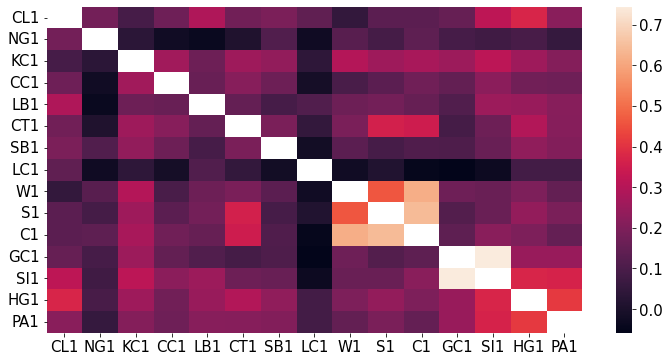

In [12]:
corrmat = retsx.corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)

corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}:\n{info.loc[pair_min[0]].Name} with {info.loc[pair_min[1]].Name}.\n')
print(f'MAX Correlation pair is {pair_max}:\n{info.loc[pair_max[0]].Name} with {info.loc[pair_max[1]].Name}.')

corrmat

***

# Performance Metrics - Bitcoin vs SPY

### Load Data from Yahoo Finance

In [13]:
import yfinance as yf
df = yf.download("SPY BTC-USD", start="2015-01-02", end="2022-06-30")['Adj Close']

[*********************100%***********************]  2 of 2 completed


### Modify data to drop NaN and convert to percentage

In [14]:
returns = df.dropna(axis=0)
returns = returns.pct_change()
returns

,BTC-USD,SPY
Date,,
2015-01-02,NaN,NaN
2015-01-05,-0.1287,-0.0181
2015-01-06,0.0427,-0.0094
2015-01-07,0.0285,0.0125
2015-01-08,-0.0373,0.0177
...,...,...
2022-05-16,0.0198,-0.0041
2022-05-17,0.0189,0.0206
2022-05-18,-0.0561,-0.0403


# Build Dataframe for Metrics

#### Construct an empty dataframe with pd.DataFrame(), set the columns of the new frame to equal the columns of the "returns" dataframe

In [15]:
metrics = pd.DataFrame(columns=returns.columns)

#### Note that these are total returns, not excess returns. Sharpe ratio is defined as the mean over vol of excess returns, but it is often extended to total returns when comparing two securities, as the subtraction of the risk-free rate makes little difference to the comparison

In [16]:
metrics.loc['mean'] = returns.mean()
metrics.loc['vol'] = returns.std()
metrics.loc['sharpe'] = returns.mean() / returns.std()

metrics.loc['mean'] *= 252
metrics.loc['vol'] *= np.sqrt(252)
metrics.loc['sharpe'] *= np.sqrt(252)

metrics

,BTC-USD,SPY
mean,0.8842,0.1213
vol,0.7317,0.1808
sharpe,1.2085,0.6708


### Plot of SPY and BTC in Cumulative Returns

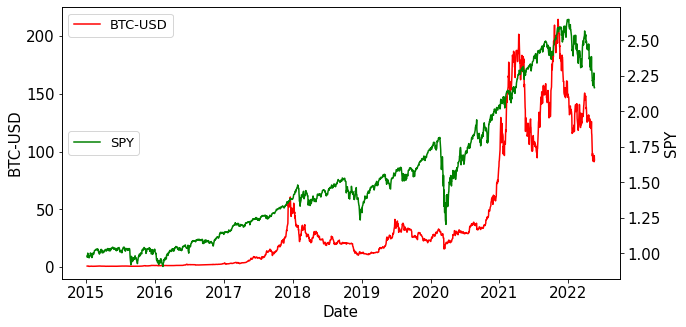

In [17]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('BTC-USD')
ax1.plot(returns.index, (1+returns['BTC-USD']).cumprod(), color='r', label='BTC-USD')

ax2 = ax1.twinx()  
ax2.set_ylabel('SPY')  
ax2.plot(returns.index, (1+returns['SPY']).cumprod(), color='g', label='SPY')

ax1.legend(loc='upper left')
ax2.legend(loc='center left')
plt.show()

## Maximum Drawdown

In [18]:
cum_returns = (1 + returns).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (cum_returns - rolling_max) / rolling_max

metrics.loc['max drawdown'] = drawdown.min()

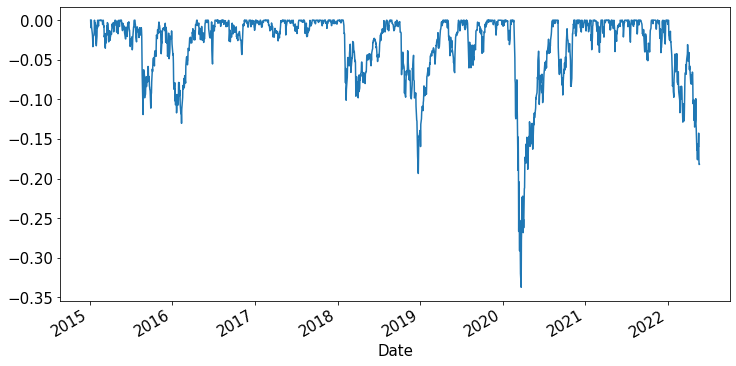

In [19]:
drawdown['SPY'].plot()
plt.show()

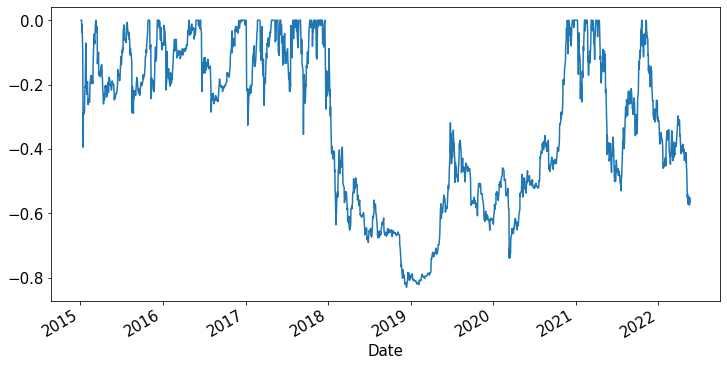

In [20]:
drawdown['BTC-USD'].plot()
plt.show()

## OLS Regression of BTC on SPY

In [21]:
y = returns['BTC-USD']
# use .add_constant on the X data to include an intercept, (to include an alpha)
X = sm.add_constant(returns['SPY'])
results = sm.OLS(y,X,missing='drop').fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                BTC-USD   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     62.17
Date:                Sun, 22 May 2022   Prob (F-statistic):           5.32e-15
Time:                        16:03:33   Log-Likelihood:                 3113.7
No. Observations:                1859   AIC:                            -6223.
Df Residuals:                    1857   BIC:                            -6212.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.000      0.0

## Information Ratio and Treynor Ratio

SPY has a market beta of 1, since we are using SPY as "the market". We could regress SPY on SPY, and we'd get alpha=0, beta=1, and residuals=0. Thus, Info ratio is undefined, Treynor ratio is simply the mean return.

In [22]:
mkt_beta = results.params['SPY']
metrics.loc['mkt beta'] = [mkt_beta, 1]

In [23]:
info_ratio = results.params['const'] / results.resid.std()
# annualize by sqrt(252)
metrics.loc['info ratio'] = [info_ratio * np.sqrt(252), None]

In [24]:
treynor_ratio = y.mean() / mkt_beta
# annualize by 252
metrics.loc['treynor ratio'] = [treynor_ratio * 252, returns['SPY'].mean() * 252]

In [25]:
metrics

,BTC-USD,SPY
mean,0.8842,0.1213
vol,0.7317,0.1808
sharpe,1.2085,0.6708
max drawdown,-0.8304,-0.3372
mkt beta,0.7283,1.0000
info ratio,1.1058,NaN
treynor ratio,1.2142,0.1213


***

# Now with Strategy Indexes

### Source HFRI Indexes
#### These funds are highly correlated

In [26]:
hf = pd.read_excel('../data/hedge_data.xls', sheet_name = [1,2], index_col = 0)
hf = pd.concat(hf.values(), axis=1)
hf.head()

,Total Index,Convertible Arbitrage,Dedicated Short Bias,Emerging Markets,Equity Market Neutral,Event Driven,Event Driven Distressed,Event Driven Multi-Strategy,Event Driven Risk Arbitrage,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Managed Futures,Multi-Strategy,Market Equity Index
date,,,,,,,,,,,,,,,
1994-04-30,-0.0196,-0.0274,0.0106,-0.0858,0.0003,-0.0088,-0.0093,-0.0079,-0.0118,-0.0042,-0.0181,-0.0178,0.0064,0.0236,0.0068
1994-05-31,0.0198,-0.0127,0.0200,-0.0098,-0.0036,-0.0040,-0.0109,0.0044,0.0000,0.0054,0.0355,0.0032,0.0051,-0.0372,0.0057
1994-06-30,-0.0104,-0.0002,0.0612,0.0024,0.0047,-0.0036,-0.0118,0.0060,-0.0005,-0.0063,-0.0115,-0.0254,0.0392,0.0338,-0.0303
1994-07-31,0.0010,-0.0011,-0.0143,0.0556,-0.0125,0.0029,0.0155,-0.0121,0.0032,-0.0043,-0.0060,0.0104,-0.0126,-0.0248,0.0281
1994-08-31,0.0256,-0.0025,-0.0587,0.1621,-0.0120,0.0061,0.0183,-0.0093,0.0148,-0.0030,0.0254,0.0143,-0.0048,-0.0345,0.0401


In [27]:
performanceMetrics(hf,annualization=12, quantile=.01)

,Mean,Vol,Sharpe,Min,Max
Total Index,0.0604,0.0732,0.8243,-0.0794,0.0813
Convertible Arbitrage,0.0458,0.0686,0.6677,-0.1277,0.0580
Dedicated Short Bias,-0.0656,0.1682,-0.3898,-0.1129,0.2232
Emerging Markets,0.0514,0.1457,0.3531,-0.2342,0.1621
Equity Market Neutral,0.0247,0.1019,0.2428,-0.4063,0.0365
Event Driven,0.0606,0.0622,0.9749,-0.1216,0.0419
Event Driven Distressed,0.0707,0.0649,1.0900,-0.1284,0.0412
Event Driven Multi-Strategy,0.0559,0.0675,0.8276,-0.1191,0.0477
Event Driven Risk Arbitrage,0.0337,0.0407,0.8259,-0.0654,0.0340
Fixed Income Arbitrage,0.0271,0.0568,0.4779,-0.1422,0.0430


In [28]:
maximumDrawdown(hf)

,Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
Total Index,-0.2285,2007-10-31,2009-02-28,2010-12-31,1157 days
Convertible Arbitrage,-0.3551,2007-10-31,2008-12-31,2010-08-31,1035 days
Dedicated Short Bias,-0.7950,1994-06-30,2012-12-31,NaT,NaT
Emerging Markets,-0.4927,1997-07-31,1999-01-31,2005-02-28,2769 days
Equity Market Neutral,-0.4590,2008-06-30,2009-02-28,NaT,NaT
Event Driven,-0.2251,2007-10-31,2009-02-28,2010-10-31,1096 days
Event Driven Distressed,-0.2655,2007-06-30,2009-03-31,2011-01-31,1311 days
Event Driven Multi-Strategy,-0.2074,2007-10-31,2009-02-28,2010-04-30,912 days
Event Driven Risk Arbitrage,-0.0990,2001-05-31,2003-03-31,2004-03-31,1035 days
Fixed Income Arbitrage,-0.3296,2007-04-30,2008-12-31,2012-01-31,1737 days


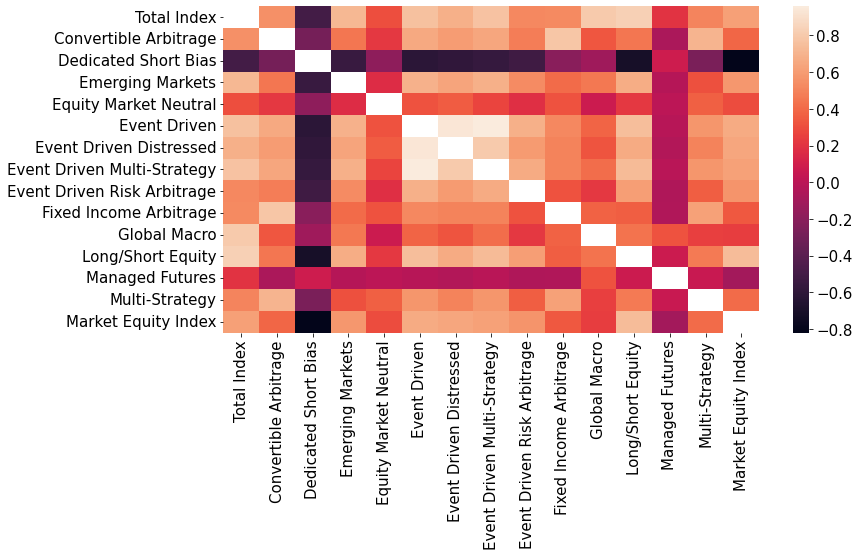

In [29]:
corrmat = hf.copy().corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)
plt.show()

In [30]:
corrmat

,Total Index,Convertible Arbitrage,Dedicated Short Bias,Emerging Markets,Equity Market Neutral,Event Driven,Event Driven Distressed,Event Driven Multi-Strategy,Event Driven Risk Arbitrage,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Managed Futures,Multi-Strategy,Market Equity Index
Total Index,NaN,0.5519,-0.5048,0.7217,0.3006,0.7595,0.6862,0.7648,0.5155,0.5259,0.7998,0.8284,0.1954,0.5037,0.6169
Convertible Arbitrage,0.5519,NaN,-0.2897,0.4484,0.2161,0.6564,0.6035,0.6398,0.4760,0.7783,0.3275,0.4496,-0.0657,0.7042,0.3869
Dedicated Short Bias,-0.5048,-0.2897,NaN,-0.5511,-0.1857,-0.6137,-0.5962,-0.5645,-0.5228,-0.2062,-0.1132,-0.7109,0.0781,-0.2674,-0.8198
Emerging Markets,0.7217,0.4484,-0.5511,NaN,0.1707,0.6932,0.6330,0.6872,0.5308,0.4043,0.4537,0.6721,-0.0220,0.3074,0.5809
Equity Market Neutral,0.3006,0.2161,-0.1857,0.1707,NaN,0.3172,0.3531,0.2689,0.1818,0.3175,0.0706,0.2180,0.0006,0.3623,0.2959
Event Driven,0.7595,0.6564,-0.6137,0.6932,0.3172,NaN,0.9371,0.9587,0.6842,0.5178,0.3805,0.7437,-0.0201,0.5706,0.6666
Event Driven Distressed,0.6862,0.6035,-0.5962,0.6330,0.3531,0.9371,NaN,0.8052,0.5957,0.4960,0.3255,0.6666,-0.0392,0.5001,0.6417
Event Driven Multi-Strategy,0.7648,0.6398,-0.5645,0.6872,0.2689,0.9587,0.8052,NaN,0.6642,0.4984,0.4152,0.7340,-0.0111,0.5730,0.6203
Event Driven Risk Arbitrage,0.5155,0.4760,-0.5228,0.5308,0.1818,0.6842,0.5957,0.6642,NaN,0.3133,0.2188,0.6095,-0.0530,0.3566,0.5650
Fixed Income Arbitrage,0.5259,0.7783,-0.2062,0.4043,0.3175,0.5178,0.4960,0.4984,0.3133,NaN,0.3729,0.3591,-0.0482,0.6244,0.3371


In [31]:
corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}.')
print(f'MAX Correlation pair is {pair_max}.')

MIN Correlation pair is ('Dedicated Short Bias', 'Market Equity Index').
MAX Correlation pair is ('Event Driven Multi-Strategy', 'Event Driven').
